# Exploratory Data Analysis on a Natural Language Processing Task
> Authors: Caroline Schmitt, Matt Brems

---

Exploratory data analysis (EDA) is a crucial part of any data science project. EDA helps us discover interesting relationships in the data, detect outliers and errors, examine our own assumptions about the data, and prepare for modeling. During EDA we might discover that we need to clean our data more conscientiously, or that we have more missing data than we realized, or that there aren't many patterns in the data (indicating that modeling may be challenging.)

In this lab you'll bring in a natural language dataset and perform EDA. The dataset contains Facebook statuses taken from between 2009 and 2011 as well as personality test results associated with the users whose Facebook statuses are included.

This dataset uses results from the Big Five Personality Test, also referred to as the five-factor model, which measures a person's score on five dimensions of personality:
- **O**penness
- **C**onscientiousness
- **E**xtroversion
- **A**greeableness
- **N**euroticism

Notoriously, the political consulting group Cambridge Analytica claims to have predicted the personalities of Facebook users by using those users' data, with the goal of targeting them with political ads that would be particularly persuasive given their personality type. Cambridge Analytica claims to have considered 32 unique 'groups' in the following fashion:
- For each of the five OCEAN qualities, a user is categorized as either 'yes' or 'no'.
- This makes for 32 different potential combinations of qualities. ($2^5 = 32$).

Cambridge Analytica's methodology was then, roughly, the following:
- Gather a large amount of data from Facebook.
- Use this data to predict an individual's Big Five personality "grouping."
- Design political advertisements that would be particularly effective to that particular "grouping." (For example, are certain advertisements particularly effective toward people with specific personality traits?)

In this lab you will perform EDA to examine many relationships in the data.

Exploratory data analysis can be a non-linear process, and you're encouraged to explore questions that occur to you as you work through the notebook.

> **Content note**: This dataset contains real Facebook statuses scraped from 2009 to 2011, and some of the statuses contain language that is not safe for work, crude, or offensive. The full dataset is available as `mypersonality.csv`, and a sanitized version containing only statuses that passed an automated profanity check is available as `mypersonality_noprofanity.csv`. Please do not hesitate to use `mypersonality_noprofanity.csv` if you would prefer to. Please note that the automated profanity check is not foolproof. If you have any concerns about working with this dataset, please get in touch with your instructors.

---

### External resources

These resources are not required reading but may be of use or interest.

- [Python Graph Gallery](https://python-graph-gallery.com/)
- [Wikipedia page](https://en.wikipedia.org/wiki/Big_Five_personality_traits) on the Big Five test
- [A short (3-4 pages) academic paper](./celli-al_wcpr13.pdf) using the `MyPersonality` dataset to model personality

---

## Load packages

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer

# this setting widens how many characters pandas will display in a column:
pd.options.display.max_colwidth = 400

---

## Load data

In [2]:
df = pd.read_csv('data/mypersonality.csv')
# df = pd.read_csv('data/mypersonality_noprofanity.csv') # comment out above & uncomment this to use mypersonality_noprofanity.csv
df.drop(columns=['NETWORKSIZE', 'BETWEENNESS', 'NBETWEENNESS', 'DENSITY', 'BROKERAGE', 'NBROKERAGE', 'TRANSITIVITY'], inplace=True)
df.head(3)

,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN,DATE
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/19/09 03:21 PM
1,b7b7764cfa1c523e4e93ab2a79a946c4,is so sleepy it's not even funny that's she can't get to sleep.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,07/02/09 08:41 AM
2,b7b7764cfa1c523e4e93ab2a79a946c4,"is sore and wants the knot of muscles at the base of her neck to stop hurting. On the other hand, YAY I'M IN ILLINOIS! <3",2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/15/09 01:15 PM


---

## EDA on Statuses

Before we even vectorize the text, we might look at the lengths and word counts in each Facebook status.

#### Create a new column called `status_length` that contains the length of each status:

In [3]:
# https://pandas.pydata.org/docs/reference/api/pandas.Series.str.len.html
df['status_length'] = df['STATUS'].str.len()
df.head()

,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN,DATE,status_length
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/19/09 03:21 PM,27
1,b7b7764cfa1c523e4e93ab2a79a946c4,is so sleepy it's not even funny that's she can't get to sleep.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,07/02/09 08:41 AM,63
2,b7b7764cfa1c523e4e93ab2a79a946c4,"is sore and wants the knot of muscles at the base of her neck to stop hurting. On the other hand, YAY I'M IN ILLINOIS! <3",2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/15/09 01:15 PM,121
3,b7b7764cfa1c523e4e93ab2a79a946c4,likes how the day sounds in this new song.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/22/09 04:48 AM,42
4,b7b7764cfa1c523e4e93ab2a79a946c4,is home. <3,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,07/20/09 02:31 AM,11


#### Create a new column called `status_word_count` that contains the number of words in each status:

Note: You can evaluate this based off of how many strings are separated by whitespaces; you're not required to check that each set of characters set apart by whitespaces is a word in the dictionary.

In [4]:
df['status_word_count'] = df['STATUS'].str.split().str.len()
df.head()

,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN,DATE,status_length,status_word_count
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/19/09 03:21 PM,27,5
1,b7b7764cfa1c523e4e93ab2a79a946c4,is so sleepy it's not even funny that's she can't get to sleep.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,07/02/09 08:41 AM,63,13
2,b7b7764cfa1c523e4e93ab2a79a946c4,"is sore and wants the knot of muscles at the base of her neck to stop hurting. On the other hand, YAY I'M IN ILLINOIS! <3",2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/15/09 01:15 PM,121,26
3,b7b7764cfa1c523e4e93ab2a79a946c4,likes how the day sounds in this new song.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/22/09 04:48 AM,42,9
4,b7b7764cfa1c523e4e93ab2a79a946c4,is home. <3,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,07/20/09 02:31 AM,11,3


### Longest and shortest statuses

Looking at individual observations can help us get a sense of what the dataset contains.

#### Show the five longest and five shortest statuses based off of `status_word_count`:

In [5]:
# shortest:
df.sort_values(by = 'status_word_count').head()

,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN,DATE,status_length,status_word_count
8178,4bbb1f5843d9d6e8966dce58179f01de,157,2.55,2.65,4.0,2.95,4.05,n,n,y,n,y,07/13/09 01:27 PM,3,1
4170,dba5f5266d03dd6d4db084ad7dbc683c,"wed,.",1.55,2.45,3.5,3.40,4.50,n,n,n,n,y,09/02/09 05:32 AM,5,1
2016,c3f4b3e345cb6b032db2e0459d179db3,HOUSE!,2.45,4.00,3.8,2.80,4.25,n,y,y,n,y,10/13/09 12:00 AM,6,1
956,e6cdef6f475cce3023c5b715f8c9f110,Err:509,1.80,2.90,2.9,3.00,4.20,n,y,n,n,y,10/10/09 07:23 PM,7,1
4177,dba5f5266d03dd6d4db084ad7dbc683c,confused,1.55,2.45,3.5,3.40,4.50,n,n,n,n,y,09/04/09 02:18 AM,8,1


In [6]:
# longest:
df.sort_values(by = 'status_word_count', ascending = False).head()

,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN,DATE,status_length,status_word_count
496,9a8cf1dcb2de1a8f70c4745a636bbb96,"Exact words when renewing DL: Me: Oh no, you can't take my license, It's my 25th b-day. How am I going to get into the bar? DMV: We gonna give you a new one over there Me: But, it won't have my picture and stuff on it. Dmv: Hold up, we can take a picture of your picture and put it on a license i think. (yelling at co-worker to see if this can be done) Yup! Me: So, I can go to the bar?! Dmv: ...",3.75,3.25,4.50,5.00,4.00,y,y,y,y,y,10/30/09 02:05 PM,413,89
6989,502db2fcfe26705ae16a46c5cb2ad2e5,"If I wear makeup, I'm fake. If I like to get dressed up, I'm a Tart. If I say what i think, I'm a bitch. If I cry sometimes, I'm a drama queen. If I have guy friends, I'm a slut. If I stand up for myself, I'm mouthy. Seems like you can't do anything now a days without being labeled.. So what, go ahead and label me, see if i give a shit. Repost this if your proud of who you are! x x",3.20,3.30,4.55,3.20,4.45,n,y,y,n,y,02/18/11 08:33 AM,384,85
5208,c85845b82e705a32f674757d8912df23,"can't believe it. I got the new Wii Fit Plus game, it has a lot of fun new games and features. However, after not using the wii fit for a few months we decided to do the fitness test stuff again. Me(since last time): +2.9 lbs, still a healthy weight and BMI, wii age 54. *PROPNAME*: -8.6lbs, reccommends a healthy weight of gaining 6lbs, wii age 32. On the positive side, I have lost 5 of the 8 l...",2.25,2.75,4.50,4.25,2.50,n,n,y,y,n,01/08/10 07:32 PM,426,84
7976,d7e500ad854a1b6ced39e53a525b8a6d,"""I said he's a fairy I do suppose//flyin thru the air in pantyhose//he may be very sexy or even cute//but he looks like a sucka in a blue and red suit//I said you need a man who's got finesse//& his whole name across his chest//he may be able to fly all thru the night//but can he rock a party til the early light//he can't satisfy you with his little worm//but I can bust you out w my Super sper...",3.25,4.25,2.75,2.00,3.75,n,y,n,n,n,10/21/09 10:39 PM,429,83
5680,1ece40ac9b657dea8c22a1fe58d3a6fe,"I always make it a rule to let the other fellow fire first. If a man wants to fight, I argue the question with him and try to show him how foolish it would be. If he can't be dissuaded, why then the fun begins but I always let him have first crack. Then when I fire, you see, I have the verdict of self-defence on my side. I know that he is pretty certain in his hurry, to miss. I never do.",3.50,1.75,4.75,3.00,4.25,n,n,y,n,y,12/07/09 04:07 AM,395,83


## What's the distribution of post lengths?

Use visuals to show the distributions of post lengths. Show both the distribution of word counts and the distribution of lengths based off character.

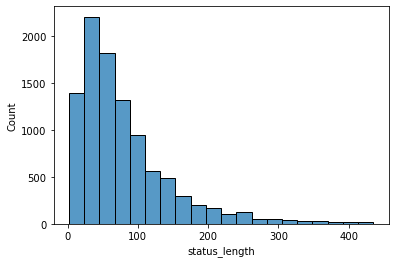

In [7]:
sns.histplot(df['status_length'], bins = 20);

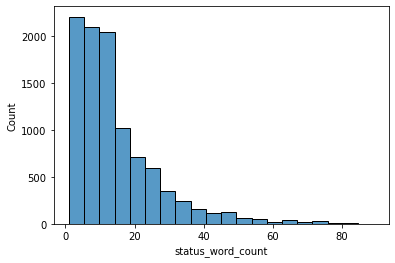

In [8]:
sns.histplot(df['status_word_count'], bins = 20);

---

## EDA of Personality Scores

There are two sets of personality columns in the dataset: class and score. According to the attached paper, scores have been converted to categories based on whether a score for a user fell above or below the median.

### Plot the distributions of personality scores for all five score columns:

''

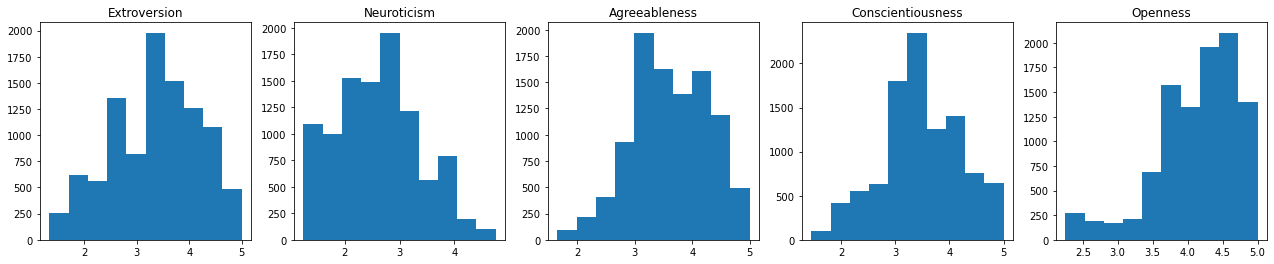

In [9]:
fig, ax = plt.subplots(1, 5, figsize = (22, 4))

ax[0].hist(df['sEXT'], bins=10)
ax[0].set_title('Extroversion')

ax[1].hist(df['sNEU'], bins=10)
ax[1].set_title('Neuroticism')

ax[2].hist(df['sAGR'], bins=10)
ax[2].set_title('Agreeableness')

ax[3].hist(df['sCON'], bins=10)
ax[3].set_title('Conscientiousness')

ax[4].hist(df['sOPN'], bins=10)
ax[4].set_title('Openness')
;



---

### How many unique users exist in the dataset?

This dataset has redacted original poster names, but each user is given an `#AUTHID`. How many unique users are there, and how many posts per user do we have?

In [10]:
# unique users:
len(df['#AUTHID'].unique())

250

In [11]:
# average posts per user
df['#AUTHID'].count() / len(df['#AUTHID'].unique())

39.664

## EDA on unique users

Because we have many posts per user for most users, doing EDA on the personality score columns might be misleading. If we have 200 Facebook statuses from one very high-conscientiousness user, a bar chart of how many `'cCON'` statuses are associated with `'y'` might be misleading. We'll have to be careful about labeling and titling any visualizations we make off of the dataset.

#### Create a new dataframe called `unique_users` that only contains the `#AUTHID`, personality score, and personality category columns:

If you do this correctly, it should have 250 rows and 11 columns.

(Hint: You can use the pandas [drop_duplicates()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html) method to make this easier. The only column you want to consider when deciding if a user is duplicated is the `#AUTHID` column.)

In [12]:
unique_users = df.drop_duplicates(subset = '#AUTHID')
unique_users.drop(['STATUS', 'DATE', 'status_length', 'status_word_count'], axis = 1, inplace = True)
unique_users

C:\Users\Lindsey\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,#AUTHID,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN
0,b7b7764cfa1c523e4e93ab2a79a946c4,2.65,3.00,3.15,3.25,4.40,n,y,n,n,y
102,318bf822d4f2bd3920367560218619c0,4.50,4.00,3.00,4.50,3.75,y,y,n,y,n
171,ecbddbfe00e0f83cfdb802a7186061c7,4.30,2.15,3.60,3.30,4.10,y,n,y,n,y
236,db39f7b2aad360b1033ec1f8fcd57f9c,4.65,3.20,3.05,3.65,4.75,y,y,n,y,y
246,4d035bd3fd8d9595d15cea9e388964be,3.70,2.90,3.40,3.35,4.05,y,y,n,n,y
...,...,...,...,...,...,...,...,...,...,...,...
9909,a764ca41dca158d7a191505dcc8ce47f,3.70,2.50,4.20,4.10,3.60,y,n,y,y,n
9910,deb899e426c1a5c66c24eeb0d7df6257,2.15,2.15,4.10,2.90,4.60,n,n,y,n,y
9912,ea28a927cb6663480ea33ca917c3c8ba,4.05,3.35,3.80,3.95,4.50,y,y,y,y,y
9914,5532642937eb3497a43e15dbb23a9d2d,1.40,4.05,3.30,3.40,3.95,n,y,n,n,y


#### Plot the distribution of personality scores for `unique_users`:

Do the distributions look different? Here, each individual user will only be represented once.

''

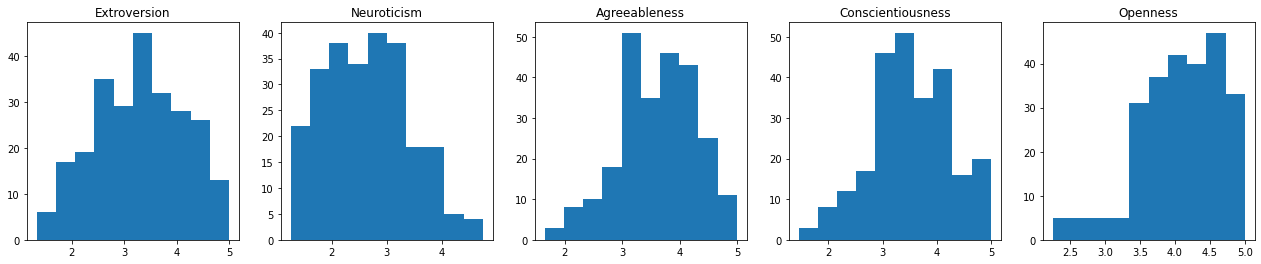

In [13]:
fig, ax = plt.subplots(1, 5, figsize = (22, 4))

ax[0].hist(unique_users['sEXT'], bins=10)
ax[0].set_title('Extroversion')

ax[1].hist(unique_users['sNEU'], bins=10)
ax[1].set_title('Neuroticism')

ax[2].hist(unique_users['sAGR'], bins=10)
ax[2].set_title('Agreeableness')

ax[3].hist(unique_users['sCON'], bins=10)
ax[3].set_title('Conscientiousness')

ax[4].hist(unique_users['sOPN'], bins=10)
ax[4].set_title('Openness')
;

Yes, they do look different:
* The plots only go up to 50 max, instead of 2000
* Extroversion originally looked like there were more extroverts, but now it is more normally distributed (extroverts must post more).
* Neuroticism looked somewhat normally distributed, but in the second version it is skewed right (neurotic people must post less).

#### Use the `.describe()` method on `unique_users`:

In [14]:
unique_users.describe()

,sEXT,sNEU,sAGR,sCON,sOPN
count,250.000000,250.000000,250.000000,250.000000,250.00000
mean,3.292120,2.627240,3.600320,3.522920,4.07856
std,0.861368,0.776835,0.670758,0.740211,0.57506
min,1.330000,1.250000,1.650000,1.450000,2.25000
25%,2.662500,2.000000,3.150000,3.000000,3.75000
50%,3.300000,2.590000,3.660000,3.500000,4.15000
75%,4.000000,3.150000,4.100000,4.050000,4.50000
max,5.000000,4.750000,5.000000,5.000000,5.00000


### Plots vs. Tables

Consider what different information is easily conveyed by the plots of scores, versus the table with summary statistics. Explain when you might present a distribution versus when you might present a table of summary statistics.

Plots:
* distribution
* approximate center

Tables:
* min and max
* exact mean
* standard deviation

A distribution is useful for presentations or displaying information in a simple way that is easy to quickly understand.<br>
A table is useful if you are looking for a specific value for any of the summary statistics.

#### Other visualizations:

Create 1-2 additional visualizations related to the `unique_users` dataframe.

You might consider:
- Barcharts of users per category per trait
- A seaborn correlation heatmap
- A seaborn pairplot

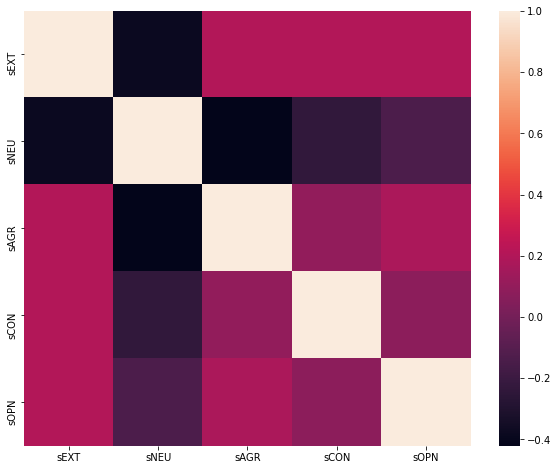

In [15]:
plt.figure(figsize = (10, 8))
sns.heatmap(unique_users.corr());

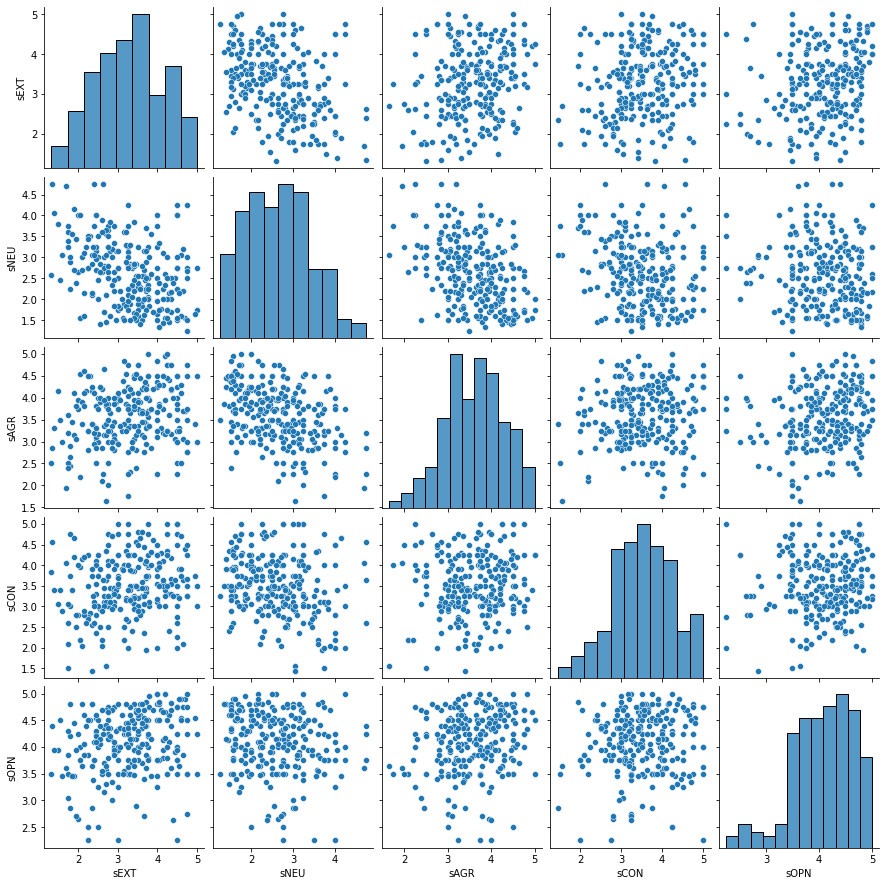

In [16]:
sns.pairplot(unique_users);

---

## Exploring status length and word count based on personality

#### Using `groupby()`, find the mean status length and status word count for posts by users in the high and low categories of each of the Big 5 traits.

You'll need to use `groupby()` five separate times for this.

In [17]:
df.groupby('cEXT')['status_length', 'status_word_count'].mean()

<ipython-input-17-34d55f685d5f>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby('cEXT')['status_length', 'status_word_count'].mean()


,status_length,status_word_count
cEXT,,
n,79.866655,14.394428
y,81.704918,14.702305


In [18]:
df.groupby('cNEU')['status_length', 'status_word_count'].mean()

<ipython-input-18-73d94e1d75aa>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby('cNEU')['status_length', 'status_word_count'].mean()


,status_length,status_word_count
cNEU,,
n,80.852396,14.548314
y,80.304278,14.486414


In [19]:
df.groupby('cAGR')['status_length', 'status_word_count'].mean()

<ipython-input-19-f4fd7ee910b6>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby('cAGR')['status_length', 'status_word_count'].mean()


,status_length,status_word_count
cAGR,,
n,80.976769,14.616692
y,80.355800,14.444276


In [20]:
df.groupby('cCON')['status_length', 'status_word_count'].mean()

<ipython-input-20-62190257f2b8>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby('cCON')['status_length', 'status_word_count'].mean()


,status_length,status_word_count
cCON,,
n,81.920149,14.709515
y,79.149034,14.308165


In [21]:
df.groupby('cOPN')['status_length', 'status_word_count'].mean()

<ipython-input-21-5410889e843e>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby('cOPN')['status_length', 'status_word_count'].mean()


,status_length,status_word_count
cOPN,,
n,85.686298,15.450726
y,78.905143,14.205184


In [22]:
df.head()

,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN,DATE,status_length,status_word_count
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/19/09 03:21 PM,27,5
1,b7b7764cfa1c523e4e93ab2a79a946c4,is so sleepy it's not even funny that's she can't get to sleep.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,07/02/09 08:41 AM,63,13
2,b7b7764cfa1c523e4e93ab2a79a946c4,"is sore and wants the knot of muscles at the base of her neck to stop hurting. On the other hand, YAY I'M IN ILLINOIS! <3",2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/15/09 01:15 PM,121,26
3,b7b7764cfa1c523e4e93ab2a79a946c4,likes how the day sounds in this new song.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/22/09 04:48 AM,42,9
4,b7b7764cfa1c523e4e93ab2a79a946c4,is home. <3,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,07/20/09 02:31 AM,11,3


#### Choose one of the personality category columns (i.e. `cOPN`, `cCON`, `cEXT`, `cAGR`, or `cNEU`.) Use `sns.distplot()` to visualize the distribution of status word counts for posts by users who score both high (`y`) and low (`n`) in that personality category:

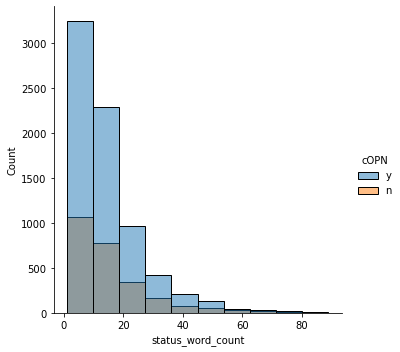

In [23]:
sns.displot(data=df, x='status_word_count', hue='cOPN', bins = 10)

---

## EDA on Word Counts

### Vectorize the text

In order to perform EDA on word count data, we'll need to count-vectorize.

Create a dataframe that contains the count-vectorized text for each Facebook status in the dataset.

To do this, you might follow these steps:
- Instantiate a `CountVectorizer` object
- Fit the count vectorizer on the Facebook statuses
- Store the transformed data
- Convert to a dataframe and store
    - Don't forget that the transformed data will need to be 'densified'. The `toarray()` or `todense()` methods will allow this.
    - Don't forget that the `get_feature_names()` method on a fitted `CountVectorizer` object will bring you back the words learned from the dataset, which you can set as the `columns` argument when creating the dataframe.
    
It's up to you whether or not to keep stopwords in the dataset.

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
cvect = CountVectorizer()
status_vect = cvect.fit_transform(df['STATUS'])

In [25]:
status_vect_array = status_vect.toarray()

In [26]:
status_words = pd.DataFrame(status_vect_array, columns = cvect.get_feature_names())
status_words

,00,000,000ft,00am,00pm,01,02,02pm,03,0330,...,équipe,étais,était,étant,état,été,être,østersund,últimas,últimos
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9911,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9912,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9913,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9914,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Show the 15 most common words

In [27]:
# code to show 15 most common words: status_words.sum().sort_values(ascending = False)
# putting into data frame to be easier to work with later

common_15 = pd.DataFrame(status_words.sum().sort_values(ascending = False)[:15], columns = ['count'])
common_15

,count
the,4982
to,4476
is,3156
and,3057
of,2093
in,1984
it,1669
for,1641
my,1564
you,1495


### Show the 15 frequency of the most common words as a bar chart

**Hint**: You can do this in one line of code. [This webpage](https://dfrieds.com/data-visualizations/bar-plot-python-pandas.html) has an example.

<AxesSubplot:>

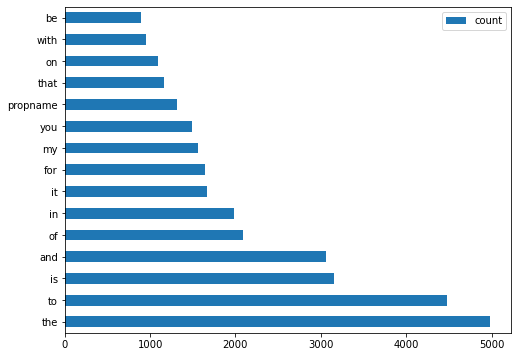

In [28]:
common_15.plot(kind='barh', figsize=(8, 6))

### Investigating `propname`

The word `propname` shows up frequently in this dataset. Show the first 10 statuses in the dataset that contain `propname`:

In [29]:
# https://stackoverflow.com/questions/11350770/select-by-partial-string-from-a-pandas-dataframe

df[df['STATUS'].str.contains('PROPNAME')][:10]

,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN,DATE,status_length,status_word_count
6,b7b7764cfa1c523e4e93ab2a79a946c4,"saw a nun zombie, and liked it. Also, *PROPNAME* + Tentacle!Man + Psychic Powers = GREAT Party.",2.65,3.00,3.15,3.25,4.40,n,y,n,n,y,06/27/09 05:41 AM,95,17
18,b7b7764cfa1c523e4e93ab2a79a946c4,"is tired. *PROPNAME*, let me go to sleep pl0x.",2.65,3.00,3.15,3.25,4.40,n,y,n,n,y,07/11/09 05:44 AM,46,9
69,b7b7764cfa1c523e4e93ab2a79a946c4,has a fair idea of how to manage the 2.5 kids cliche... She just needs a very strong gentleman named *PROPNAME* and thriteen wet napkins.,2.65,3.00,3.15,3.25,4.40,n,y,n,n,y,11/24/09 05:07 AM,137,25
101,b7b7764cfa1c523e4e93ab2a79a946c4,has a serious crush on *PROPNAME*. <3,2.65,3.00,3.15,3.25,4.40,n,y,n,n,y,01/25/10 02:57 AM,37,7
104,318bf822d4f2bd3920367560218619c0,Mondays are the new thursdays- anthony bourdain + *PROPNAME* = forgetting your financial troubles,4.50,4.00,3.00,4.50,3.75,y,y,n,y,n,06/23/09 05:41 AM,98,14
118,318bf822d4f2bd3920367560218619c0,is *PROPNAME*'s bestbian,4.50,4.00,3.00,4.50,3.75,y,y,n,y,n,08/23/09 06:03 AM,24,3
139,318bf822d4f2bd3920367560218619c0,is in love with *PROPNAME*.,4.50,4.00,3.00,4.50,3.75,y,y,n,y,n,10/04/09 03:09 AM,27,5
158,318bf822d4f2bd3920367560218619c0,is in love. With *PROPNAME*.,4.50,4.00,3.00,4.50,3.75,y,y,n,y,n,12/11/09 05:35 AM,28,5
170,318bf822d4f2bd3920367560218619c0,Ten Movies to Watch Right Now (and some you can Instant Netflix) 1. La Vie En Rose 2. Shrink (if you love LA) 3. Paris Je'taime (if you love Paris) 3. Clay Pidgeons (*PROPNAME* is priceless) 4. Quills 5. Away We Go 6. Sunshine Cleaning 7. A League of Their Own 8. Smart People (I Heart *PROPNAME*'s Page and SJP) 9. Frost//Nixon 10. Doubt,4.50,4.00,3.00,4.50,3.75,y,y,n,y,n,10/11/09 01:39 AM,338,64
202,ecbddbfe00e0f83cfdb802a7186061c7,"ATTENTION EVERYONE!!! Vote for the short ""AFTER HOURS"" to support *PROPNAME* - our local Michigan talent and a wonderful person. Repost please!!! http:////www.thirteen.org//sites//reel13//category//vote//",4.30,2.15,3.60,3.30,4.10,y,n,y,n,y,11/24/09 07:11 AM,204,23


#### Provide a short explanation of what you believe `propname` to be:

Hint: The attached PDF also contains an explanation.

For each instance that a proper name of person appears, it has been replaced with a fixed string (*PROPNAME*). Any name that is a famous person or city will remain as the original word.

## Most common words based on personality category

In order to do more targeted EDA, we'll need to be able to reference not only the dataframe of vectorized statuses, but also the personality scores from the original dataframe.

#### Create a new dataframe called `text_and_scores` that concatenates the count-vectorized statuses side-by-side with the original personality category columns:

In [30]:
# 'cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN'
text_and_scores = pd.concat([df[['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN']], status_words], axis = 1)
text_and_scores

,cEXT,cNEU,cAGR,cCON,cOPN,00,000,000ft,00am,00pm,...,équipe,étais,était,étant,état,été,être,østersund,últimas,últimos
0,n,y,n,n,y,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,n,y,n,n,y,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,n,y,n,n,y,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,n,y,n,n,y,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,n,y,n,n,y,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9911,n,n,y,n,y,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9912,y,y,y,y,y,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9913,y,y,y,y,y,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9914,n,y,n,n,y,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Show the 25 most common words for statuses from high-cAGR users:

In [31]:
cAGR = text_and_scores[text_and_scores['cAGR'] == 'y']
cAGR = cAGR.drop(columns = ['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN'])
cAGR.sum().sort_values(ascending = False)[:25]

the         2581
to          2411
is          1686
and         1590
of          1156
in           986
for          891
it           857
my           847
you          821
propname     699
that         600
on           570
with         506
be           485
me           449
at           426
this         417
just         402
have         386
all          370
so           365
not          340
can          328
her          324
dtype: int64

#### Show the 25 most common words for statuses from low-cAGR users:

In [32]:
no_cAGR = text_and_scores[text_and_scores['cAGR'] == 'n']
no_cAGR = no_cAGR.drop(columns = ['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN'])
no_cAGR.sum().sort_values(ascending = False)[:25]

the         2401
to          2065
is          1470
and         1467
in           998
of           937
it           812
for          750
my           717
you          674
propname     610
that         558
on           524
with         450
be           409
at           370
me           367
so           361
not          343
this         343
have         334
just         315
can          308
but          303
all          279
dtype: int64

### (BONUS) Most common bigrams:

This is a bonus section and not required.

Find the 10 most common bigrams in the dataset.

### (BONUS) Most common trigrams:

This is a bonus section and not required.

Find the 10 most common trigrams in the dataset.

---

## Choose your own adventure

By now you've looked at a lot of visualizations and frequency counts.

Come up with 2-3 questions about the data, and try to answer them using descriptive statistics (like counts, averages, etc.) or visualizations.

Some questions you might explore:
- Have numbers been redacted, or are phone numbers, house numbers, or zip codes anywhere in the dataset?
- `PROPNAME` has been used to redact personal names. Given that this data was scraped between 2009 and 2011, investigate if any public figures or famous people show up in the dataset, or their names have been redacted as well.
- Is count of uppercase letters vs. lowercase letters per status related to any personality category or personality score?
- Is _average_ word count per status related to any personality category or personality metric?
- Is punctuation use related to personality?

Or, of course, come up with your own questions to investigate!

The focus here is on "explore" -- you might not find anything of particular interest, but don't let that discourage you.

* PROPNAME has been used to redact personal names. Given that this data was scraped between 2009 and 2011, investigate if any public figures or famous people show up in the dataset, or their names have been redacted as well.

Barack Obama was president, so I did a search for his name. It looks like public figures are still shown in the dataset.

In [33]:
df[df['STATUS'].str.contains('Obama')][:10]

,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN,DATE,status_length,status_word_count
799,c19a4fb5e846fb6575b0a8f3a2081ea0,prøver å forsvare Obama til min norsk romkamerat på norsk og det er utrolig vanskelig.,3.25,3.75,1.75,4.00,3.50,n,y,n,y,n,08/19/09 08:50 PM,86,15
2096,8f9d4ed5d16ed1a67d734196d29d1f6b,Can Obama will the US to victory over Brazil Sunday?,4.33,2.00,4.17,3.67,4.40,y,n,y,y,y,06/27/09 11:24 PM,52,10
3881,9f320ade181aa12bf10361871afa8d90,"An Obama consultant yesterday on taxing high-value, middle class health care plans: ""We're not talking about a new tax on these people. We're saying they currently get an enormous tax break and we're going to slightly scale that back . . ."" This will likely be the talking point for any new, middle-class taxes to come.",1.80,3.00,2.45,3.75,2.85,n,y,n,y,n,01/12/10 04:41 PM,319,56
6355,1886cffe45f0ee0240eda42e44a01e07,@_@ turkeyday for me = a bunch of republicans coming together eating a huge feast and Obama bashing....its disgusting!,4.75,1.25,3.50,3.25,3.50,y,n,n,n,n,11/27/09 04:20 AM,118,19
6555,8d7faa6d7f104a6cb7c4a9e1c6310a15,is temporarily upset with Obama for being in a commercial with *PROPNAME*.,3.65,2.55,4.20,3.45,4.55,y,n,y,n,y,10/06/09 05:17 AM,74,12
7493,1187ed8a8b100eb49b8684ac30d6da29,President Obama -- fighting wars in two countries -- will arrive in Norway on Thursday to accept the Nobel Peace Prize.... Amusing CNN headline,4.00,4.00,2.25,4.50,3.25,y,y,n,y,n,12/10/09 12:21 AM,143,24
7518,1187ed8a8b100eb49b8684ac30d6da29,Obama got the Nobel Peace Prize the same day that we bombed the moon... interesting...,4.00,4.00,2.25,4.50,3.25,y,y,n,y,n,10/09/09 03:50 PM,86,15
8495,a40e2ef8193f5273a04cc7bbaae0789c,... Obama won the Nobel Peace Prize? Weird.,4.00,2.50,4.50,3.75,5.00,y,n,y,y,y,10/09/09 03:19 PM,44,8
8833,7d41c244db4ee816029991d903cc7ce1,"yeah Obama, let's fix this thing!",2.25,2.75,3.25,3.50,4.50,n,n,n,y,y,08/14/09 07:31 PM,33,6


* Is average word count per status related to any personality category or personality metric?

Being an extrovert usually means slightly more words in a status.

In [34]:
Extrovert = df.groupby('cEXT')['status_length', 'status_word_count'].mean()
Extrovert.reset_index(inplace = True)

<ipython-input-34-a3d58f1184e8>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  Extrovert = df.groupby('cEXT')['status_length', 'status_word_count'].mean()


In [35]:
Extrovert['cEXT'] = Extrovert['cEXT'].map({'n': 'No', 'y': 'Yes'})

In [36]:
Extrovert

,cEXT,status_length,status_word_count
0,No,79.866655,14.394428
1,Yes,81.704918,14.702305


---

## Exploratory vs. Explanatory Data Analysis 

> **Exploratory analysis** is what you do to get familiar with the data. You may start out with a hypothesis or question, or you may just really be delving into the data to determine what might be interesting about it. Exploratory analysis is the process of turning over 100 rocks to find perhaps 1 or 2 precious gemstones.
>
> **Explanatory analysis** is what happens when you have something specific you want to show an audience - probably about those 1 or 2 precious gemstones. In blogging and presenting, you'll focus mostly on this latter piece, explanatory analysis, when you've already gone through the exploratory analysis and from this have determined something specific you want to communicate to a given audience. In other words, when you want to tell a story with data.

- Cole Nussbaumer Knaflic, [exploratory vs. explanatory analysis](http://www.storytellingwithdata.com/blog/2014/04/exploratory-vs-explanatory-analysis)

### Choose one visual to explain:

Now that you've performed an exploratory data analysis, choose a visual (or 1-3 related visuals) to frame as _explanatory_. This can be a visual you created above, or you can create a new visual. For this visual, make sure the visuals are formatted clearly. Provide a one to two paragraph explanation/interpretation of the visual.

Text(0, 0.5, 'Word Count')

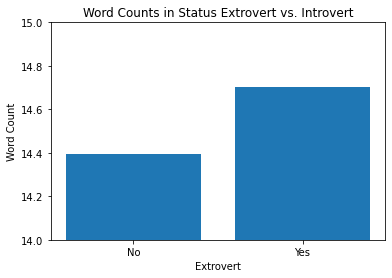

In [37]:
plt.bar(x = Extrovert['cEXT'], height = Extrovert['status_word_count'])
plt.ylim([14, 15])
plt.title('Word Counts in Status Extrovert vs. Introvert')
plt.xlabel('Extrovert')
plt.ylabel('Word Count')

The bar chart shows that there is a clear difference between Extrovert and Introverts when it comes to word count in Facebook statuses. On average, extroverts post statuses with 14.7 words while introverts post 14.4 words. This is somewhat expected for the personality traits. However, since the number is still within the 14-15 word count range for both groups we can assume there is not much variation overall.